# Práctico 2: Recomendación de videojuegos

En este práctico trabajaremos con un subconjunto de datos sobre [videojuegos de Steam](http://cseweb.ucsd.edu/~jmcauley/datasets.html#steam_data). Para facilitar un poco el práctico, se les dará el conjunto de datos previamente procesado. En este mismo notebook mostraremos el proceso de limpieza, para que quede registro del proceso (de todas maneras, por el tamaño de los datos no recomendamos que pierdan tiempo en el proceso salvo que lo consideren útil a fines personales). 

El conjunto de datos se basa en dos partes: lista de juegos (items), y lista de reviews de usuarios sobre distintos juegos. Este último, en su versión original es muy grande, (pesa 1.3GB), por lo que será solo una muestra del mismo sobre la que trabajarán.

A diferencia del conjunto de datos de LastFM utilizados en el [Práctico 1](./practico1.ipynb), en este caso los datos no están particularmente pensados para un sistema de recomendación, por lo que requerirá de un poco más de trabajo general sobre el dataset.

La idea es que, de manera similar al práctico anterior, realicen un sistema de recomendación. A diferencia del práctico anterior, este será un poco más completo y deberán hacer dos sistemas, uno que, dado un nombre de usuario le recomiende una lista de juegos, y otro que dado el título de un juego, recomiende una lista de juegos similares. Además, en este caso se requiere que el segundo sistema (el que recomienda juegos basado en el nombre de un juego en particular) haga uso de la información de contenido (i.e. o bien harán un filtrado basado en contenido o algo híbrido).

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
import sklearn
from surprise import KNNBaseline, SVD, BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering
from surprise import accuracy
from surprise import SVD
from surprise import Dataset, Reader, KNNWithMeans, KNNBasic#, NormalPredictor, KNNWithZScore
from surprise.accuracy import rmse
from surprise.model_selection import cross_validate, train_test_split

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

## Obtención y limpieza del conjunto de datos

El conjunto de datos originalmente se encuentra en archivos que deberían ser de formato "JSON". Sin embargo, en realidad es un archivo donde cada línea es un objeto de JSON. Hay un problema no obstante y es que las líneas están mal formateadas, dado que no respetan el estándar JSON de utilizar comillas dobles (**"**) y en su lugar utilizan comillas simples (**'**). Afortunadamente, se pueden evaluar como diccionarios de Python, lo cuál permite trabajarlos directamente.

# DESCARGA de datos

In [122]:
%%bash

mkdir -p data/steam/
curl -L -o data/steam/games.json.gz https://cs.famaf.unc.edu.ar/\~ccardellino/diplomatura/games.json.gz
curl -L -o data/steam/reviews.json.gz https://cs.famaf.unc.edu.ar/\~ccardellino/diplomatura/reviews.json.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1927k  100 1927k    0     0  9540k      0 --:--:-- --:--:-- --:--:-- 9540k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  121M  100  121M    0     0  11.1M      0  0:00:10  0:00:10 --:--:-- 11.1M


## Ejercicio 1: Análisis Exploratorio de Datos

Ya teniendo los datos, podemos cargarlos y empezar con el práctico. Antes que nada vamos a hacer una exploración de los datos. Lo principal a tener en cuenta para este caso es que debemos identificar las variables con las que vamos a trabajar. A diferencia del práctico anterior, este conjunto de datos no está documentado, por lo que la exploración es necesaria para poder entender que cosas van a definir nuestro sistema de recomendación.

### Características del conjunto de datos sobre videojuegos

Las características del conjunto de datos de videojuegos tienen la información necesaria para hacer el "vector de contenido" utilizado en el segundo sistema de recomendación. Su tarea es hacer un análisis sobre dicho conjunto de datos y descartar aquella información redundante.

# Descriptive statistics

Casi 80 por ciento de los usuarios solamente hizo un review.


In [3]:
games = pd.read_json("./data/steam/games.json.gz")
games.shape

(32135, 14)

In [4]:
# fix weird trailing decimal thing
integer_id = []
for i in games['id']:
    string = str(i)
    integer_id.append(string[:-2])
games['id'] = integer_id

In [5]:
games.head()

,publisher,genres,app_name,title,release_date,tags,discount_price,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,[Single-player],4.99,False,761140,Kotoshiro,None,None
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,None
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,None
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,2017-12-07,"[Action, Adventure, Casual]",0.83,[Single-player],0.99,False,767400,彼岸领域,None,None
4,None,None,Log Challenge,None,None,"[Action, Indie, Casual, Sports]",1.79,"[Single-player, Full controller support, HTC V...",2.99,False,773570,None,None,None


In [6]:
games.count()

publisher         24083
genres            28852
app_name          32133
title             30085
release_date      30068
tags              31972
discount_price      225
specs             31465
price             30758
early_access      32135
id                32135
developer         28836
sentiment         24953
metascore          2677
dtype: int64

### Características del conjunto de datos de reviews

Este será el conjunto de datos a utilizar para obtener información sobre los usuarios y su interacción con videojuegos. Como se puede observar no hay un rating explícito, sino uno implícito a calcular, que será parte de su trabajo (deberán descubrir que característica les puede dar información que puede ser equivalente a un rating).

In [7]:
reviews = pd.read_json("./data/steam/reviews.json.gz")
reviews.head()

,username,product_id,page_order,text,hours,products,date,early_access,page,compensation,found_funny,user_id
0,SPejsMan,227940,0,Just one word... Balance!,23.0,92.0,2015-02-25,True,3159,None,NaN,NaN
1,Spodermen,270170,4,Graphics: none\nMusic: Makes me want to sleep\...,4.9,217.0,2014-08-26,False,231,None,NaN,7.656120e+16
2,josh,41700,1,"cheeki breeki iv danke, stalker",53.2,78.0,2015-12-25,False,191,None,NaN,NaN
3,Sammyrism,332310,9,I am really underwhelmed by the small about of...,16.2,178.0,2015-06-04,True,570,None,NaN,NaN
4,moonmirroir,303210,9,"I came into the game expecting nothing, of cou...",1.8,13.0,2015-10-02,False,967,None,NaN,NaN


## Reviews Dataset

In [8]:
print("Number of registers: ",(len(reviews['username'])))
user_freq = reviews['username'].value_counts()
print("Number of total unique users:",(len(user_freq)))


Number of registers:  700000
Number of total unique users: 495383


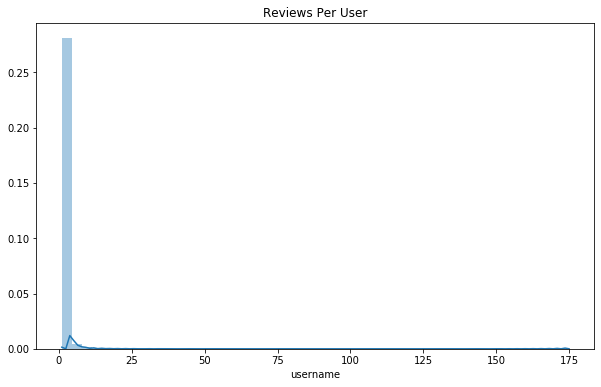

In [9]:
#Para conocer como se distribuyen los datos de listens realizamos un histograma
plt.figure(figsize=(10,6))
sns.distplot(user_freq).set_title("Reviews Per User");

In [10]:
#user_names are the names of users who reviewed more than one videogame
user_names = []
for idx, review in enumerate(user_freq):
    if user_freq[idx] > 1:
        user_names.append(review)

In [11]:
print("Total number or reviews:",len(reviews.username))
print("Total number of unique users:",len(user_freq))
print("Count of users who reviewed more than one videogames:",len(user_names))
print("Count of users who reviewed only one videogame:",(len(user_freq))-(len(user_names)))
print("Percent of users who reviewed more than one videogame:",(len(user_names))*100/(len(user_freq)))

Total number or reviews: 700000
Total number of unique users: 495383
Count of users who reviewed more than one videogames: 94943
Count of users who reviewed only one videogame: 400440
Percent of users who reviewed more than one videogame: 19.1655749188002


# the variable ```reviews['hours']```

In [12]:
print("Max number of hours playing: ",reviews['hours'].max())
print("Min number of hours playing: ",reviews['hours'].min())

Max number of hours playing:  18570.9
Min number of hours playing:  0.0


In [13]:
# Asimetría y curtosis:
print("Mean: %f" % reviews['hours'].mean())
print("Median: %f" % reviews['hours'].median())
print("Mode: %f" % reviews['hours'].median())
print("Standard Deviation: %f" % reviews['hours'].std())
print("Variance: %f" % reviews['hours'].var())
print("Skewness: %f" % reviews['hours'].skew())
print("Kurtosis: %f" % reviews['hours'].kurt())

Mean: 111.498797
Median: 15.200000
Mode: 15.200000
Standard Deviation: 385.359458
Variance: 148501.911706
Skewness: 10.765634
Kurtosis: 209.051640


# This code creates ```user_ids``` from the ```string``` usernames.

In [14]:
# this makes our dictionary with the key database for all unique usernames
username_id_dict = {}
for idx, names in enumerate(reviews['username'].unique()[:4000]):
    username_id_dict[reviews['username'].unique()[idx]] = idx
print(len(username_id_dict))

4000


In [15]:
username_id_column = []
for i in reviews['username'][:4000]:
    if i in username_id_dict:
        username_new = username_id_dict[i]
        username_id_column.append(username_new)
print(len(username_id_column))

4000


Make two more dictionaries for encoding and decoding our recommendation system later

In [16]:
# this makes our dictionary with the key database for all unique usernames
username_ids = {}
for idx, names in enumerate(reviews['username'].unique()[:4000]):
    username_ids[idx] = reviews['username'].unique()[idx]
print(len(username_ids))

4000


In [17]:
# this makes our dictionary with the key database for all unique games
gamename_dict = {}
for idx, names in enumerate(games['app_name']):
    if games['id'][idx] not in gamename_dict:
        gamename_dict[games['id'][idx]] = games['app_name'][idx] 
    else:
        continue
print(len(gamename_dict))

32133


# PET SET: Make the dataset smaller

In [18]:
small_df = reviews[:4000].fillna(0)
small_df['user_id'] = username_id_column
small_df.to_csv("small_reviews.csv")

In [19]:
#small_df = pd.read_csv("small_reviews.csv")

# Added a new column with ```user_id```

In [20]:
# Now with a user_id
small_df.head(2)

,username,product_id,page_order,text,hours,products,date,early_access,page,compensation,found_funny,user_id
0,SPejsMan,227940,0,Just one word... Balance!,23.0,92.0,2015-02-25,True,3159,0,0.0,0
1,Spodermen,270170,4,Graphics: none\nMusic: Makes me want to sleep\...,4.9,217.0,2014-08-26,False,231,0,0.0,1


### Conclusion: A lot of people played games for a short time and some people played games for an extremely long time.

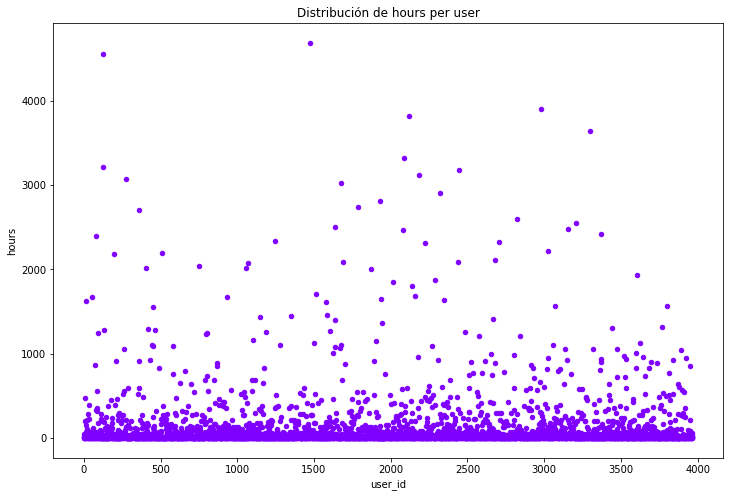

In [21]:
PURPLE = '#8000ff'
small_df.plot(figsize=(12,8), kind='scatter', x='user_id', y='hours', title='Distribución de hours per user', color=PURPLE)

# Matrices and Models

In [22]:
reader = Reader(rating_scale=(small_df.hours.min(), small_df.hours.max()))
videogames = Dataset.load_from_df(small_df[["user_id", "product_id", "hours"]], reader)

In [23]:
ratings_train, ratings_test = train_test_split(videogames, test_size=0.4)

In [24]:
model = KNNWithMeans(k=5).fit(ratings_train)
predictions = model.test(ratings_test)
print("RMSE on test: {:.4f}".format(rmse(predictions, verbose=False)))

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE on test: 317.2230


**Cross Validation** 

In [25]:
model = KNNWithMeans(k=5, verbose=False)
cross_validated_metrics = cross_validate(model, videogames, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    291.3671322.4299305.2318359.2118360.6894327.786028.0497 
MAE (testset)     137.7352145.3974143.0954153.4019144.0554144.73715.0537  
Fit time          0.25    0.24    0.24    0.24    0.25    0.24    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


In [26]:
model = SVD(n_factors=100, n_epochs=20, random_state=42).fit(ratings_train)
predictions = model.test(ratings_test)
print("RMSE on test: {:.4f}".format(rmse(predictions, verbose=False)))

RMSE on test: 1797.6454


In [27]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (user_id, product_id, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        game_mapper: dict that maps movie id's to game indices
        game_inv_mapper: dict that maps movie indices to game id's
    """
    M = df['user_id'].nunique()
    N = df['product_id'].nunique()

    user_mapper = dict(zip(np.unique(df['user_id']), list(range(M))))
    game_mapper = dict(zip(np.unique(df['product_id']), list(range(N))))
    
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df['user_id'])))
    game_inv_mapper = dict(zip(list(range(N)), np.unique(df['product_id'])))
    
    user_index = [user_mapper[i] for i in df['user_id']]
    item_index = [game_mapper[i] for i in df['product_id']]

    X = csr_matrix((df['hours'], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, game_mapper, user_inv_mapper, game_inv_mapper

X, user_mapper, game_mapper, user_inv_mapper, game_inv_mapper = create_X(small_df)

In [28]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 0.06%


In [29]:
n_weight_per_user = X.getnnz(axis=1)
print(f"Los usuarios más activos jugaron {n_weight_per_user.max()} games.")
print(f"Los usuarios menos activos jugaron {n_weight_per_user.min()} game.")

Los usuarios más activos jugaron 3 games.
Los usuarios menos activos jugaron 1 game.


In [30]:
n_weight_per_game = X.getnnz(axis=0)
print(f"El videogame más jugado tiene {n_weight_per_game.max()} plays.")
print(f"El videogame menos escuchado tiene {n_weight_per_game.min()} plays.")

El videogame más jugado tiene 93 plays.
El videogame menos escuchado tiene 1 plays.


In [31]:
sum_weights_per_game = X.sum(axis=0)
mean_weight_per_game = sum_weights_per_game/n_weight_per_game

In [32]:
X_mean_game = np.tile(mean_weight_per_game, (X.shape[0],1))

We will need ```X_norm``` for the item-item recommendation system.

In [33]:
X_norm = X - csr_matrix(X_mean_game)

## Ejercicio 2 - User-based Sistema de Recomendación

Este sistema de recomendación deberá entrenar un algoritmo y desarrollar una interfaz que, dado un usuario, le devuelva una lista con los juegos más recomendados.

### Set up our functions for encoding and decoding the names

In [34]:
# encode gamenames
def encode(gamename):
    for number, name in gamename_dict.items():
        if name == gamename:
            id_number = number
    return id_number
print(encode("Beach Rules"))

768880


In [35]:
# encode usernames
def encode_user(username):
    for number, name in username_ids.items():
        if name == username:
            id_number = number
    return id_number
print(encode_user("Spodermen"))

1


In [36]:
# decode gamenames
def decode(id_number):
    for number, name in gamename_dict.items():
        if str(id_number) == number:
            gamename = name
    return gamename
print(decode(768880))

Beach Rules


In [37]:
# decode
def decode_user(user_id):
    for number, name in username_ids.items():
        if user_id == number:
            username = name
        else:
            name = "Nothing"
    return username
print(decode_user(1))

Spodermen


## Rec-sys #1: Given user, return a list of suggested games

In [38]:
Mean = small_df.groupby(by="user_id",as_index=False)['hours'].mean()
rating_avg = pd.merge(small_df,Mean,on='user_id')
#Rating_avg['adg_rating']=Rating_avg['rating_x']-Rating_avg['rating_y']
rating_avg.head(10)

,username,product_id,page_order,text,hours_x,products,date,early_access,page,compensation,found_funny,user_id,hours_y
0,SPejsMan,227940,0,Just one word... Balance!,23.0,92.0,2015-02-25,True,3159,0,0.0,0,23.0
1,Spodermen,270170,4,Graphics: none\nMusic: Makes me want to sleep\...,4.9,217.0,2014-08-26,False,231,0,0.0,1,4.9
2,josh,41700,1,"cheeki breeki iv danke, stalker",53.2,78.0,2015-12-25,False,191,0,0.0,2,53.2
3,Sammyrism,332310,9,I am really underwhelmed by the small about of...,16.2,178.0,2015-06-04,True,570,0,0.0,3,16.2
4,moonmirroir,303210,9,"I came into the game expecting nothing, of cou...",1.8,13.0,2015-10-02,False,967,0,0.0,4,1.8
5,brotherdave84,311340,4,"i havent got to play this game yet,IT WILL NOT...",45.8,8.0,2014-12-25,False,406,0,0.0,5,45.8
6,Amaraen,422970,1,If you enjoy skill-based FPS games and don't m...,35.6,803.0,2016-06-22,False,205,0,3.0,6,35.6
7,CaptainPlanet,214950,1,"If you like slaughtering in the name of Rome, ...",203.3,274.0,2016-10-27,False,285,0,0.0,7,203.3
8,BlacKobra246,440,6,Good game\nI recommend this game\nbecause is g...,2.5,7.0,2015-05-10,False,14090,0,1.0,8,2.5
9,TpaXep,526790,0,Hi! My name's Sasha Zenko. I'm from Belarus.\n...,0.7,1213.0,2016-10-23,False,21,Product received for free,2.0,9,0.7


We want to make two seperate matrices for ```games``` and ```users``` and fill the ```NaN```s with the mean.

In [39]:
check = pd.pivot_table(small_df,values='hours',index='user_id',columns='product_id')
check.head()

product_id,50,60,70,80,130,220,240,280,300,320,...,703840,709820,713530,714270,722730,728870,733990,734580,738380,758230
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
final = pd.pivot_table(small_df,values='hours',index='user_id',columns='product_id')
final.head()

product_id,50,60,70,80,130,220,240,280,300,320,...,703840,709820,713530,714270,722730,728870,733990,734580,738380,758230
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# Replacing NaN with game average
final_games = final.fillna(final.mean(axis=0))
# Replacing NaN with user average
final_user = final.apply(lambda row: row.fillna(row.mean()), axis=1)
final_games.head()

product_id,50,60,70,80,130,220,240,280,300,320,...,703840,709820,713530,714270,722730,728870,733990,734580,738380,758230
user_id,,,,,,,,,,,,,,,,,,,,,
0,9.15,4.15,148.4625,119.966667,2.9,33.716667,293.766667,13.3,9.2,11.35,...,1.0,0.3,0.7,0.8,1.5,0.7,12.1,28.8,0.5,0.1
1,9.15,4.15,148.4625,119.966667,2.9,33.716667,293.766667,13.3,9.2,11.35,...,1.0,0.3,0.7,0.8,1.5,0.7,12.1,28.8,0.5,0.1
2,9.15,4.15,148.4625,119.966667,2.9,33.716667,293.766667,13.3,9.2,11.35,...,1.0,0.3,0.7,0.8,1.5,0.7,12.1,28.8,0.5,0.1
3,9.15,4.15,148.4625,119.966667,2.9,33.716667,293.766667,13.3,9.2,11.35,...,1.0,0.3,0.7,0.8,1.5,0.7,12.1,28.8,0.5,0.1
4,9.15,4.15,148.4625,119.966667,2.9,33.716667,293.766667,13.3,9.2,11.35,...,1.0,0.3,0.7,0.8,1.5,0.7,12.1,28.8,0.5,0.1


In [42]:
final_user.head()

product_id,50,60,70,80,130,220,240,280,300,320,...,703840,709820,713530,714270,722730,728870,733990,734580,738380,758230
user_id,,,,,,,,,,,,,,,,,,,,,
0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,...,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0
1,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9,...,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9
2,53.2,53.2,53.2,53.2,53.2,53.2,53.2,53.2,53.2,53.2,...,53.2,53.2,53.2,53.2,53.2,53.2,53.2,53.2,53.2,53.2
3,16.2,16.2,16.2,16.2,16.2,16.2,16.2,16.2,16.2,16.2,...,16.2,16.2,16.2,16.2,16.2,16.2,16.2,16.2,16.2,16.2
4,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,...,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8


Use ```cosine_similarity``` to normalize

In [43]:
# user similarity on replacing NAN by item(games) avg
cosine = cosine_similarity(final_games)
np.fill_diagonal(cosine, 0 )
similarity_with_game = pd.DataFrame(cosine,index=final_games.index)
similarity_with_game.columns=final_user.index
similarity_with_game.head()

user_id,0,1,2,3,4,5,6,7,8,9,...,3957,3958,3959,3960,3961,3962,3963,3964,3965,3966
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.999199,0.999199,0.999194,0.999199,0.999192,0.999195,0.998921,0.990719,0.999199,...,0.999199,0.999199,0.999199,0.999199,0.999199,0.999195,0.999199,0.999188,0.999199,0.999199
1,0.999199,0.000000,1.000000,0.999995,1.000000,0.999993,0.999996,0.999721,0.991543,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.999996,1.000000,0.999989,1.000000,1.000000
2,0.999199,1.000000,0.000000,0.999995,1.000000,0.999993,0.999996,0.999721,0.991543,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.999996,1.000000,0.999989,1.000000,1.000000
3,0.999194,0.999995,0.999995,0.000000,0.999995,0.999987,0.999991,0.999715,0.991538,0.999995,...,0.999994,0.999995,0.999995,0.999995,0.999995,0.999990,0.999995,0.999984,0.999995,0.999994
4,0.999199,1.000000,1.000000,0.999995,0.000000,0.999992,0.999996,0.999721,0.991543,1.000000,...,0.999999,1.000000,1.000000,1.000000,1.000000,0.999995,1.000000,0.999989,1.000000,1.000000


In [44]:
# user similarity on replacing NAN by user avg
b = cosine_similarity(final_user)
np.fill_diagonal(b, 0 )
similarity_with_user = pd.DataFrame(b,index=final_user.index)
similarity_with_user.columns=final_user.index
similarity_with_user.head()

user_id,0,1,2,3,4,5,6,7,8,9,...,3957,3958,3959,3960,3961,3962,3963,3964,3965,3966
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [45]:
def find_n_neighbours(df,n):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=False)
           .iloc[:n].index, 
          index=['top{}'.format(i) for i in range(1, n+1)]), axis=1)
    return df

In [46]:
# top 10 neighbors for each user
sim_user_10_u = find_n_neighbours(similarity_with_user,10)
sim_user_10_u.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
user_id,,,,,,,,,,
0,4,190,718,721,723,3386,3387,258,3807,1937
1,3608,2045,3851,1704,3100,3413,544,3773,3587,2959
2,4,3294,168,3608,2669,2959,3587,3773,316,1743
3,4,3076,2977,2990,2995,3028,489,474,473,2692
4,2916,225,1810,474,711,364,2435,1743,3851,316


In [47]:
# top 10 neighbours for each user
sim_user_10_m = find_n_neighbours(similarity_with_game,10)
sim_user_10_m.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
user_id,,,,,,,,,,
0,1279,3231,548,1326,319,2716,1527,666,3611,3786
1,2,9,10,12,3011,2997,1942,3001,1208,1213
2,1,9,10,12,3011,2997,1942,3001,1208,1213
3,2085,1565,44,2285,3265,2679,1818,411,750,405
4,1745,1559,508,1246,3137,872,2483,3142,1244,1248


In [48]:
rating_avg = rating_avg.astype({"product_id": str})
game_user = rating_avg.groupby(by = 'user_id')['product_id'].apply(lambda x:','.join(x))

In [49]:
def user_rec(user):
    user_ID = encode_user(user)
    recs = []
    games_played_by_user = check.columns[check[check.index==user_ID].notna().any()].tolist()
    a = sim_user_10_m[sim_user_10_m.index==user_ID].values
    b = a.squeeze().tolist()
    d = game_user[game_user.index.isin(b)]
    l = ','.join(d.values)
    games_played_by_similar_users = l.split(',')
    games_under_consideration = list(set(games_played_by_similar_users)-set(list(map(str, games_played_by_user))))
    games_under_consideration = list(map(int, games_under_consideration))
    score = []
    for item in games_under_consideration:
        c = final_games.loc[:,item]
        d = c[c.index.isin(b)]
        f = d[d.notnull()]
        avg_user = Mean.loc[Mean['user_id'] == user_ID,'hours'].values[0]
        index = f.index.values.squeeze().tolist()
        corr = similarity_with_game.loc[user_ID,index]
        fin = pd.concat([f, corr], axis=1)
        fin.columns = ['adg_score','correlation']
        fin['score']=fin.apply(lambda x:x['adg_score'] * x['correlation'],axis=1)
        nume = fin['score'].sum()
        deno = fin['correlation'].sum()
        final_score = avg_user + (nume/deno)
        score.append(final_score)
    data = pd.DataFrame({'product_id':games_under_consideration,'score':score})
    top_5_recommendation = data.sort_values(by='score',ascending=False).head(5)
    for i in top_5_recommendation['product_id']: 
        recs.append(decode(i))
    return recs

just to see what the options are

In [50]:
print(reviews['username'][:10])

0         SPejsMan
1        Spodermen
2             josh
3        Sammyrism
4      moonmirroir
5    brotherdave84
6          Amaraen
7    CaptainPlanet
8     BlacKobra246
9           TpaXep
Name: username, dtype: object


In [51]:
#print(user_rec('josh'))
print("Enter a username to whom you want to recommend a videogame: (Type 99 to exit)")
user_n = input('>>>>')
print(user_rec(user_n))

Enter a username to whom you want to recommend a videogame: (Type 99 to exit)
>>>>Spodermen
['S.T.A.L.K.E.R.: Call of Pripyat', 'Doom & Destiny', 'Empire: Total War™', 'Hexcells Infinite', 'How to Survive 2']


## Ejercicio 3 - Sistema de Recomendación Basado en Juegos

Similar al caso anterior, con la diferencia de que este sistema espera como entrada el nombre de un juego y devuelve una lista de juegos similares. El sistema deberá estar programado en base a información de contenido de los juegos (i.e. filtrado basado en contenido o sistema híbrido).

In [52]:
from sklearn.neighbors import NearestNeighbors

def find_similar_games(game_id, X, game_mapper, game_inv_mapper, k, metric='cosine'):
    """
    Encuentra k-nearest neighbours por cada game ID.
    
    Args:
        game_id: ID del game de interes
        X: user-item de matriz de utilidad
        k: numero de games similares que devuelve
        metric: medida de distancia 
    
    Output: devuelve una lista de k games ID similares. 
    """
    X = X.T
    neighbour_ids = []
    game_ind = game_mapper[game_id]
    game_vec = X[game_ind]
    if isinstance(game_vec, (np.ndarray)):
        game_vec = game_vec.reshape(1,-1)
    # use k+1 since kNN output includes the artistId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(game_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(game_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [53]:
def rec_game(game):
    '''Given a string videogame name, this function \
    returns a list of videogame recommendations'''
    recs = []
    game_id = encode(game)
    game_int = int(game_id)
    similar_games = find_similar_games(game_int, X, game_mapper, game_inv_mapper, k=10)
    for i in similar_games:
        recs.append(decode(i))
    return recs

## Choose a game from below:

In [54]:
# just to see the names
for i in games['app_name'][60:80]:
    print(i)

Zen of Sudoku
Gumboy - Crazy Adventures™
Ghost Master®
Vegas: Make It Big™
Dreamfall: The Longest Journey
FlatOut 2™
FlatOut
Lost Planet™: Extreme Condition
CivCity: Rome
Arx Fatalis
The Longest Journey
Civilization IV®: Warlords
Railroad Tycoon 3
Sid Meier's Railroads!
None
Railroad Tycoon II Platinum
RIP - Trilogy™
X-COM: Terror From the Deep
Tomb Raider: Anniversary
Devil May Cry® 3 Special Edition


In [58]:
# try LEGO® Worlds
#print(rec_game('LEGO® Worlds'))
print("Enter the name of your favorite videogame from the database. (Type 99 to exit)")
game = input(">>>>")
print(rec_game(game))

Enter the name of your favorite videogame from the database. (Type 99 to exit)
>>>>LEGO® Worlds
['NARUTO SHIPPUDEN: Ultimate Ninja STORM 4', 'Bloodbath Kavkaz', 'Bierzerkers', 'Beyond Sol', 'Rise & Shine', 'Voices from the Sea', 'Environmental Station Alpha', "Romero's Aftermath", 'AdVenture Capitalist']
